In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')

In [3]:
def load_dataset():
    train_dataset = h5py.File('dataset/train_signs.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:])
    train_set_y_orig = np.array(train_dataset['train_set_y'][:])
    
    test_dataset = h5py.File('dataset/test_signs.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])
    
    classes = np.array(test_dataset["list_classes"][:])
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# 1. Vấn đề của mạng quá sâu
Lợi ích của một very deep network là nó có thể biểu diễn được các chức năng rất phức tạp. Nó cũng có thể tìm hiểu các chức năng ở cấp độ trừu tượng khác nhau, từ các cạnh (ở layer thấp hơn) đến các đặc trưng rất phức tạp (ở các layer sâu hơn). Tuy nhiên việc sử dụng mạng sâu không phải lúc nào cũng hữu ích. Một rào cản lớn đối việc đào tạo chúng là vanishing gradients. Trong quá trình gradient descent, chúng ta backprop từ layer cuối cùng về layer đầu tiên, chúng ta nhân với ma trận trọng số trên mỗi bước, và do đó gradient có thể giảm theo cấp số nhân nhanh chóng đến 0 (hoặc trong trường hợp hiếm hoi tăng theo cấp số nhân nhanh chóng và "explode" để nhận giá trị rất lớn).

# 2. Building a Residual Network
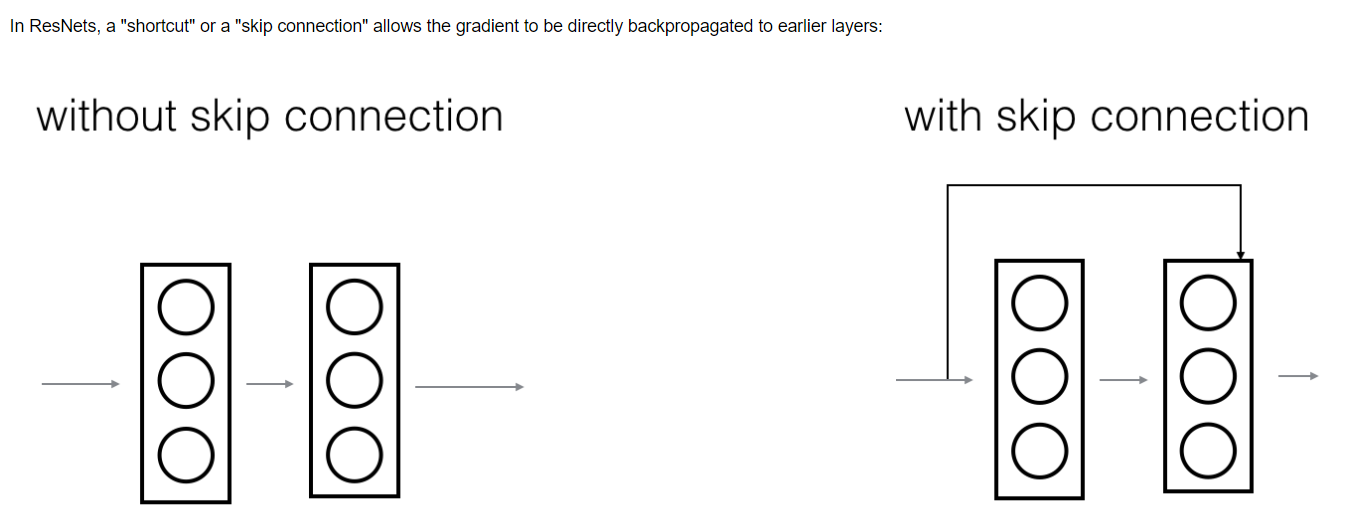


## 2.1 The identity block
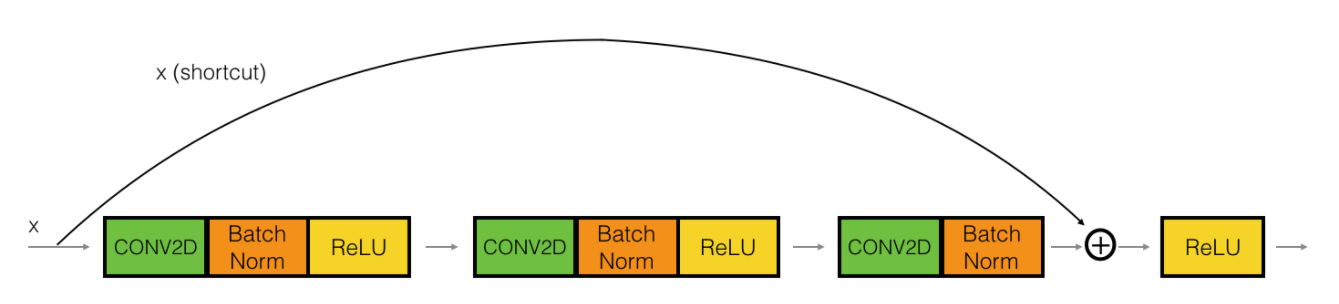

In [1]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure above

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    # Second component of the main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of the main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    # Final step
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## 2.2 The convolutional block
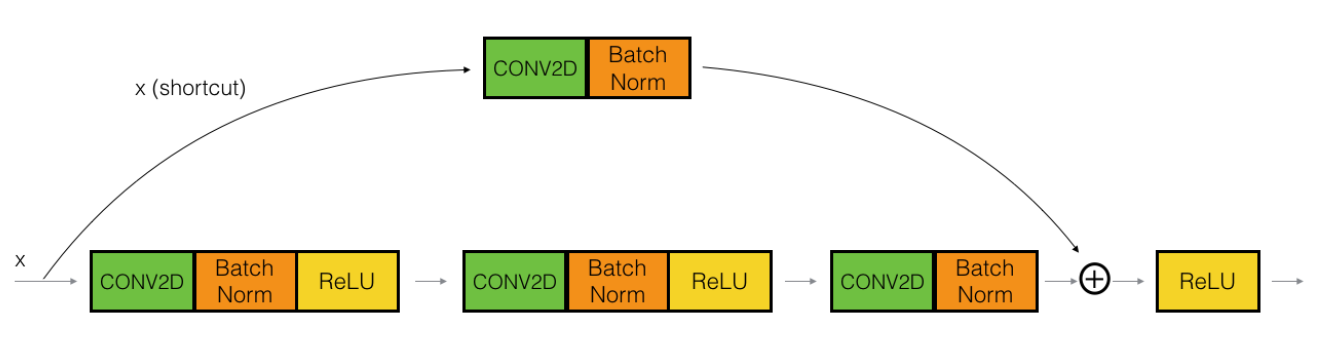